## Update
-Add Batch Normalization layer after each conv
-Add shuffle=True in model.fit() method for a better BN effect (so that we have different batch to normalize in each epoch during the training)
-You can use crf method (https://www.kaggle.com/meaninglesslives/apply-crf) to improve the result 
## Changelog
- Changed uncov to uconv, but removed the dropout in the last layer
- Corrected sanity check of predicted validation data (changed from ids_train to ids_valid)
- Used correct mask (from original train_df) for threshold tuning (inserted y_valid_ori)

In [63]:
% reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# About
Since I am new to learning from image segmentation and kaggle in general I want to share my noteook.
I saw it is similar to others as it uses the U-net approach. I want to share it anyway because:

- As said, the field is new to me so I am open to suggestions.
- It visualizes some of the steps, e.g. scaling, to learn if the methods do what I expect which might be useful to others (I call them sanity checks).
- Added stratification by the amount of salt contained in the image.
- Added augmentation by flipping the images along the y axes (thanks to the forum for clarification).
- Added dropout to the model which seems to improve performance.

In [1]:
import numpy as np
import pandas as pd

from random import randint

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout,BatchNormalization
from keras.layers import Conv2D, Concatenate, MaxPooling2D
from keras.layers import UpSampling2D, Dropout, BatchNormalization
from tqdm import tqdm_notebook

Using TensorFlow backend.


# Params and helpers

In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

# Loading of training/testing ids and depths
Reading the training data and the depths, store them in a DataFrame. Also create a test DataFrame with entries from depth not in train.

In [3]:
train_df = pd.read_csv("train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

# Read images and masks
Load the images and masks into the DataFrame and divide the pixel values by 255.

In [4]:
train_df["images"] = [np.array(load_img("train/images/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

In [5]:
train_df["masks"] = [np.array(load_img("train/masks/{}.png".format(idx), grayscale=True)) / 255 for idx in tqdm_notebook(train_df.index)]

# Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only.
Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [6]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [7]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Coverage class')

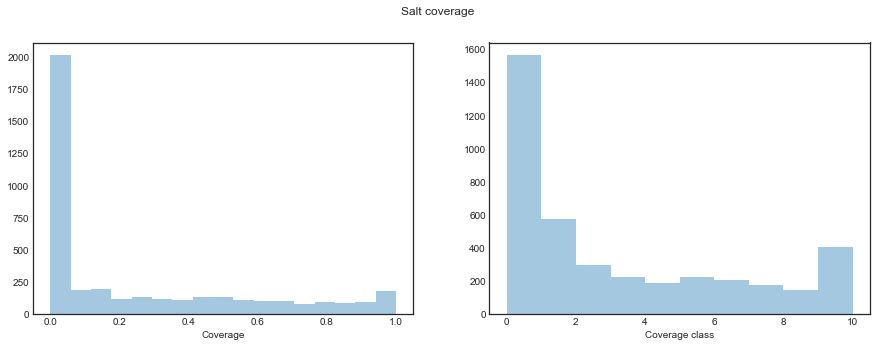

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

Text(0,0.5,'Coverage class')

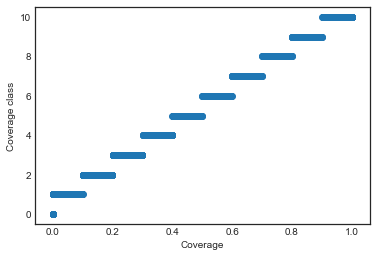

In [9]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

# Plotting the depth distributions
Separatelty plotting the depth distributions for the training and the testing data.

C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Ferhat\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Depth distribution')

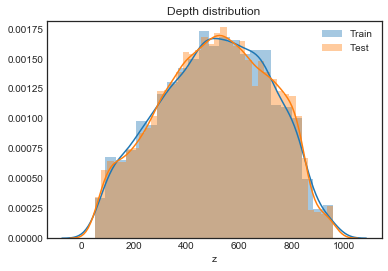

In [10]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

# Show some example images

Text(0.5,0.98,'Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

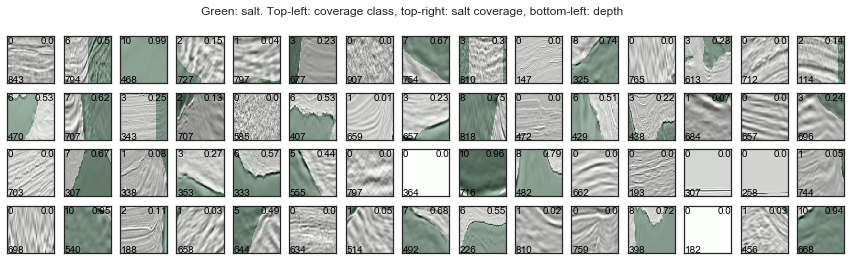

In [11]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [12]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

Text(0.5,1,'Scaled image')

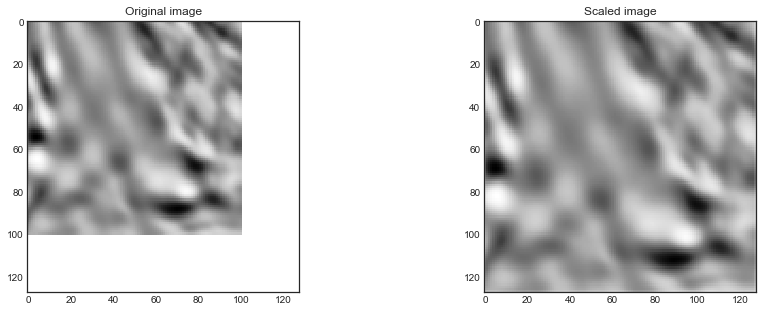

In [13]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

# Build model

In [15]:
def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

In [16]:
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=7,batchnorm=True)

In [17]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 1, 1, 2048)   8192        conv2d_16[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_1 (UpSampling2D)  (None, 2, 2, 2048)   0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 2, 2, 1024)   8389632     up_sampling2d_1[0][0]            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2, 2, 2048)   0           batch_normalization_14[0][0]     
                                                                 conv2d_17[0][0]                  
__________________________________________________________________________________________________
conv2d_18 

concatenate_6 (Concatenate)     (None, 64, 64, 64)   0           batch_normalization_4[0][0]      
                                                                 conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 64, 64, 32)   18464       concatenate_6[0][0]              
__________________________________________________________________________________________________
batch_normalization_27 (BatchNo (None, 64, 64, 32)   128         conv2d_33[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 64, 64, 32)   9248        batch_normalization_27[0][0]     
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 64, 64, 32)   128         conv2d_34[0][0]                  
__________

# Data augmentation

In [19]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

Text(0.5,0.98,'Top row: original images, bottom row: augmented images')

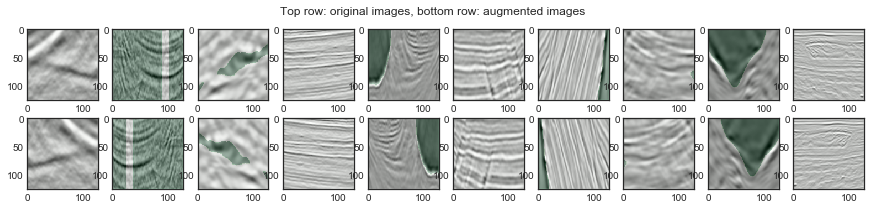

In [20]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

# Training

In [21]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],shuffle=True)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - ETA: 45:46 - loss: 0.9087 - acc: 0.49 - ETA: 23:22 - loss: 0.8593 - acc: 0.51 - ETA: 15:53 - loss: 0.8146 - acc: 0.53 - ETA: 12:09 - loss: 0.7816 - acc: 0.54 - ETA: 9:54 - loss: 0.7696 - acc: 0.5637 - ETA: 8:24 - loss: 0.7506 - acc: 0.573 - ETA: 7:20 - loss: 0.7366 - acc: 0.581 - ETA: 6:32 - loss: 0.7178 - acc: 0.592 - ETA: 5:54 - loss: 0.7019 - acc: 0.603 - ETA: 5:24 - loss: 0.7040 - acc: 0.610 - ETA: 4:59 - loss: 0.6898 - acc: 0.621 - ETA: 4:38 - loss: 0.6759 - acc: 0.633 - ETA: 4:21 - loss: 0.6761 - acc: 0.638 - ETA: 4:06 - loss: 0.6723 - acc: 0.645 - ETA: 3:53 - loss: 0.6581 - acc: 0.657 - ETA: 3:41 - loss: 0.6523 - acc: 0.665 - ETA: 3:31 - loss: 0.6444 - acc: 0.672 - ETA: 3:22 - loss: 0.6428 - acc: 0.677 - ETA: 3:13 - loss: 0.6318 - acc: 0.686 - ETA: 3:06 - loss: 0.6257 - acc: 0.690 - ETA: 2:59 - loss: 0.6238 - acc: 0.696 - ETA: 2:53 - loss: 0.6199 - acc: 0.702 - ETA: 2:47 - los

6400/6400 [==============================] - ETA: 1:14 - loss: 0.4187 - acc: 0.847 - ETA: 1:13 - loss: 0.3179 - acc: 0.890 - ETA: 1:13 - loss: 0.3325 - acc: 0.879 - ETA: 1:13 - loss: 0.3892 - acc: 0.849 - ETA: 1:12 - loss: 0.3641 - acc: 0.858 - ETA: 1:11 - loss: 0.3604 - acc: 0.861 - ETA: 1:11 - loss: 0.3667 - acc: 0.857 - ETA: 1:10 - loss: 0.3573 - acc: 0.861 - ETA: 1:10 - loss: 0.3501 - acc: 0.865 - ETA: 1:09 - loss: 0.3441 - acc: 0.867 - ETA: 1:09 - loss: 0.3373 - acc: 0.870 - ETA: 1:08 - loss: 0.3309 - acc: 0.873 - ETA: 1:08 - loss: 0.3311 - acc: 0.872 - ETA: 1:08 - loss: 0.3308 - acc: 0.874 - ETA: 1:07 - loss: 0.3308 - acc: 0.875 - ETA: 1:07 - loss: 0.3337 - acc: 0.872 - ETA: 1:06 - loss: 0.3272 - acc: 0.875 - ETA: 1:06 - loss: 0.3290 - acc: 0.874 - ETA: 1:05 - loss: 0.3336 - acc: 0.869 - ETA: 1:05 - loss: 0.3369 - acc: 0.871 - ETA: 1:05 - loss: 0.3388 - acc: 0.871 - ETA: 1:04 - loss: 0.3389 - acc: 0.872 - ETA: 1:04 - loss: 0.3376 - acc: 0.871 - ETA: 1:04 - loss: 0.3345 - acc: 0.8

6400/6400 [==============================] - ETA: 1:14 - loss: 0.1776 - acc: 0.926 - ETA: 1:12 - loss: 0.2504 - acc: 0.901 - ETA: 1:11 - loss: 0.2622 - acc: 0.894 - ETA: 1:11 - loss: 0.2936 - acc: 0.877 - ETA: 1:10 - loss: 0.2651 - acc: 0.891 - ETA: 1:10 - loss: 0.2596 - acc: 0.896 - ETA: 1:09 - loss: 0.2688 - acc: 0.887 - ETA: 1:09 - loss: 0.2728 - acc: 0.887 - ETA: 1:08 - loss: 0.2797 - acc: 0.884 - ETA: 1:08 - loss: 0.2855 - acc: 0.881 - ETA: 1:08 - loss: 0.2768 - acc: 0.886 - ETA: 1:07 - loss: 0.2782 - acc: 0.884 - ETA: 1:07 - loss: 0.2741 - acc: 0.886 - ETA: 1:07 - loss: 0.2702 - acc: 0.888 - ETA: 1:06 - loss: 0.2677 - acc: 0.890 - ETA: 1:06 - loss: 0.2640 - acc: 0.893 - ETA: 1:06 - loss: 0.2650 - acc: 0.892 - ETA: 1:05 - loss: 0.2673 - acc: 0.890 - ETA: 1:05 - loss: 0.2723 - acc: 0.888 - ETA: 1:04 - loss: 0.2792 - acc: 0.887 - ETA: 1:04 - loss: 0.2825 - acc: 0.885 - ETA: 1:04 - loss: 0.2808 - acc: 0.886 - ETA: 1:03 - loss: 0.2804 - acc: 0.886 - ETA: 1:03 - loss: 0.2762 - acc: 0.8

6400/6400 [==============================] - ETA: 1:14 - loss: 0.1457 - acc: 0.947 - ETA: 1:12 - loss: 0.1931 - acc: 0.924 - ETA: 1:11 - loss: 0.1843 - acc: 0.924 - ETA: 1:11 - loss: 0.1791 - acc: 0.926 - ETA: 1:10 - loss: 0.1878 - acc: 0.920 - ETA: 1:10 - loss: 0.1849 - acc: 0.920 - ETA: 1:09 - loss: 0.1914 - acc: 0.916 - ETA: 1:09 - loss: 0.2027 - acc: 0.911 - ETA: 1:09 - loss: 0.2034 - acc: 0.909 - ETA: 1:08 - loss: 0.2034 - acc: 0.909 - ETA: 1:08 - loss: 0.1979 - acc: 0.912 - ETA: 1:07 - loss: 0.1967 - acc: 0.913 - ETA: 1:07 - loss: 0.2090 - acc: 0.907 - ETA: 1:07 - loss: 0.2132 - acc: 0.904 - ETA: 1:06 - loss: 0.2173 - acc: 0.903 - ETA: 1:06 - loss: 0.2149 - acc: 0.906 - ETA: 1:06 - loss: 0.2172 - acc: 0.902 - ETA: 1:05 - loss: 0.2137 - acc: 0.904 - ETA: 1:05 - loss: 0.2155 - acc: 0.903 - ETA: 1:04 - loss: 0.2137 - acc: 0.904 - ETA: 1:04 - loss: 0.2129 - acc: 0.905 - ETA: 1:04 - loss: 0.2117 - acc: 0.906 - ETA: 1:03 - loss: 0.2140 - acc: 0.905 - ETA: 1:03 - loss: 0.2134 - acc: 0.9

6400/6400 [==============================] - ETA: 1:14 - loss: 0.2500 - acc: 0.874 - ETA: 1:12 - loss: 0.2126 - acc: 0.888 - ETA: 1:11 - loss: 0.1983 - acc: 0.899 - ETA: 1:11 - loss: 0.1927 - acc: 0.904 - ETA: 1:10 - loss: 0.1922 - acc: 0.906 - ETA: 1:10 - loss: 0.2008 - acc: 0.904 - ETA: 1:09 - loss: 0.1891 - acc: 0.910 - ETA: 1:09 - loss: 0.2056 - acc: 0.906 - ETA: 1:09 - loss: 0.1980 - acc: 0.910 - ETA: 1:08 - loss: 0.1996 - acc: 0.911 - ETA: 1:08 - loss: 0.1954 - acc: 0.913 - ETA: 1:08 - loss: 0.2016 - acc: 0.910 - ETA: 1:07 - loss: 0.1942 - acc: 0.913 - ETA: 1:07 - loss: 0.1914 - acc: 0.915 - ETA: 1:07 - loss: 0.1898 - acc: 0.915 - ETA: 1:06 - loss: 0.1910 - acc: 0.914 - ETA: 1:06 - loss: 0.1889 - acc: 0.916 - ETA: 1:05 - loss: 0.1898 - acc: 0.915 - ETA: 1:05 - loss: 0.1926 - acc: 0.914 - ETA: 1:05 - loss: 0.1931 - acc: 0.913 - ETA: 1:04 - loss: 0.1891 - acc: 0.915 - ETA: 1:04 - loss: 0.1887 - acc: 0.916 - ETA: 1:03 - loss: 0.1884 - acc: 0.915 - ETA: 1:03 - loss: 0.1878 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.2769 - acc: 0.900 - ETA: 1:11 - loss: 0.2915 - acc: 0.873 - ETA: 1:11 - loss: 0.2484 - acc: 0.894 - ETA: 1:10 - loss: 0.2553 - acc: 0.893 - ETA: 1:10 - loss: 0.2440 - acc: 0.896 - ETA: 1:10 - loss: 0.2336 - acc: 0.900 - ETA: 1:09 - loss: 0.2405 - acc: 0.901 - ETA: 1:09 - loss: 0.2272 - acc: 0.908 - ETA: 1:08 - loss: 0.2351 - acc: 0.905 - ETA: 1:08 - loss: 0.2265 - acc: 0.909 - ETA: 1:08 - loss: 0.2415 - acc: 0.900 - ETA: 1:07 - loss: 0.2413 - acc: 0.900 - ETA: 1:07 - loss: 0.2330 - acc: 0.904 - ETA: 1:07 - loss: 0.2276 - acc: 0.906 - ETA: 1:06 - loss: 0.2259 - acc: 0.906 - ETA: 1:06 - loss: 0.2320 - acc: 0.902 - ETA: 1:05 - loss: 0.2278 - acc: 0.904 - ETA: 1:05 - loss: 0.2336 - acc: 0.902 - ETA: 1:05 - loss: 0.2305 - acc: 0.903 - ETA: 1:04 - loss: 0.2289 - acc: 0.903 - ETA: 1:04 - loss: 0.2284 - acc: 0.903 - ETA: 1:04 - loss: 0.2277 - acc: 0.904 - ETA: 1:03 - loss: 0.2263 - acc: 0.904 - ETA: 1:03 - loss: 0.2254 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.1228 - acc: 0.944 - ETA: 1:11 - loss: 0.1127 - acc: 0.951 - ETA: 1:10 - loss: 0.1123 - acc: 0.951 - ETA: 1:10 - loss: 0.1452 - acc: 0.937 - ETA: 1:10 - loss: 0.1534 - acc: 0.938 - ETA: 1:09 - loss: 0.1846 - acc: 0.922 - ETA: 1:09 - loss: 0.1711 - acc: 0.928 - ETA: 1:09 - loss: 0.1820 - acc: 0.924 - ETA: 1:08 - loss: 0.1764 - acc: 0.925 - ETA: 1:08 - loss: 0.1716 - acc: 0.926 - ETA: 1:08 - loss: 0.1688 - acc: 0.927 - ETA: 1:07 - loss: 0.1722 - acc: 0.924 - ETA: 1:07 - loss: 0.1717 - acc: 0.924 - ETA: 1:07 - loss: 0.1908 - acc: 0.915 - ETA: 1:06 - loss: 0.1931 - acc: 0.913 - ETA: 1:06 - loss: 0.1946 - acc: 0.912 - ETA: 1:06 - loss: 0.1896 - acc: 0.914 - ETA: 1:05 - loss: 0.1872 - acc: 0.916 - ETA: 1:05 - loss: 0.1880 - acc: 0.916 - ETA: 1:04 - loss: 0.1890 - acc: 0.916 - ETA: 1:04 - loss: 0.1895 - acc: 0.916 - ETA: 1:04 - loss: 0.1903 - acc: 0.915 - ETA: 1:03 - loss: 0.1977 - acc: 0.912 - ETA: 1:03 - loss: 0.1979 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.0923 - acc: 0.956 - ETA: 1:12 - loss: 0.1390 - acc: 0.940 - ETA: 1:11 - loss: 0.1488 - acc: 0.936 - ETA: 1:11 - loss: 0.1411 - acc: 0.939 - ETA: 1:10 - loss: 0.1342 - acc: 0.942 - ETA: 1:10 - loss: 0.1293 - acc: 0.945 - ETA: 1:09 - loss: 0.1373 - acc: 0.941 - ETA: 1:09 - loss: 0.1296 - acc: 0.946 - ETA: 1:09 - loss: 0.1387 - acc: 0.938 - ETA: 1:08 - loss: 0.1322 - acc: 0.942 - ETA: 1:08 - loss: 0.1343 - acc: 0.940 - ETA: 1:08 - loss: 0.1376 - acc: 0.938 - ETA: 1:07 - loss: 0.1360 - acc: 0.939 - ETA: 1:07 - loss: 0.1357 - acc: 0.939 - ETA: 1:06 - loss: 0.1368 - acc: 0.938 - ETA: 1:06 - loss: 0.1413 - acc: 0.936 - ETA: 1:06 - loss: 0.1404 - acc: 0.937 - ETA: 1:05 - loss: 0.1457 - acc: 0.934 - ETA: 1:05 - loss: 0.1464 - acc: 0.934 - ETA: 1:05 - loss: 0.1562 - acc: 0.931 - ETA: 1:04 - loss: 0.1530 - acc: 0.932 - ETA: 1:04 - loss: 0.1523 - acc: 0.932 - ETA: 1:03 - loss: 0.1563 - acc: 0.930 - ETA: 1:03 - loss: 0.1543 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.3305 - acc: 0.845 - ETA: 1:11 - loss: 0.3363 - acc: 0.853 - ETA: 1:11 - loss: 0.2751 - acc: 0.877 - ETA: 1:10 - loss: 0.2403 - acc: 0.891 - ETA: 1:10 - loss: 0.2349 - acc: 0.890 - ETA: 1:09 - loss: 0.2205 - acc: 0.897 - ETA: 1:09 - loss: 0.2305 - acc: 0.893 - ETA: 1:09 - loss: 0.2149 - acc: 0.901 - ETA: 1:08 - loss: 0.2139 - acc: 0.902 - ETA: 1:08 - loss: 0.2105 - acc: 0.903 - ETA: 1:08 - loss: 0.2002 - acc: 0.909 - ETA: 1:07 - loss: 0.1989 - acc: 0.909 - ETA: 1:07 - loss: 0.2005 - acc: 0.910 - ETA: 1:07 - loss: 0.1952 - acc: 0.912 - ETA: 1:06 - loss: 0.1900 - acc: 0.915 - ETA: 1:06 - loss: 0.1889 - acc: 0.916 - ETA: 1:06 - loss: 0.1904 - acc: 0.915 - ETA: 1:05 - loss: 0.1874 - acc: 0.918 - ETA: 1:05 - loss: 0.1882 - acc: 0.917 - ETA: 1:04 - loss: 0.1823 - acc: 0.920 - ETA: 1:04 - loss: 0.1777 - acc: 0.922 - ETA: 1:04 - loss: 0.1780 - acc: 0.921 - ETA: 1:03 - loss: 0.1794 - acc: 0.920 - ETA: 1:03 - loss: 0.1837 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.1271 - acc: 0.941 - ETA: 1:11 - loss: 0.1067 - acc: 0.953 - ETA: 1:11 - loss: 0.1036 - acc: 0.957 - ETA: 1:10 - loss: 0.1110 - acc: 0.955 - ETA: 1:10 - loss: 0.1232 - acc: 0.949 - ETA: 1:10 - loss: 0.1158 - acc: 0.952 - ETA: 1:10 - loss: 0.1269 - acc: 0.947 - ETA: 1:09 - loss: 0.1364 - acc: 0.939 - ETA: 1:09 - loss: 0.1333 - acc: 0.941 - ETA: 1:09 - loss: 0.1311 - acc: 0.942 - ETA: 1:08 - loss: 0.1315 - acc: 0.942 - ETA: 1:08 - loss: 0.1258 - acc: 0.945 - ETA: 1:07 - loss: 0.1256 - acc: 0.946 - ETA: 1:07 - loss: 0.1265 - acc: 0.945 - ETA: 1:07 - loss: 0.1276 - acc: 0.945 - ETA: 1:06 - loss: 0.1459 - acc: 0.937 - ETA: 1:06 - loss: 0.1446 - acc: 0.937 - ETA: 1:05 - loss: 0.1419 - acc: 0.938 - ETA: 1:05 - loss: 0.1434 - acc: 0.937 - ETA: 1:05 - loss: 0.1427 - acc: 0.937 - ETA: 1:04 - loss: 0.1441 - acc: 0.935 - ETA: 1:04 - loss: 0.1417 - acc: 0.937 - ETA: 1:04 - loss: 0.1428 - acc: 0.935 - ETA: 1:03 - loss: 0.1430 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.1364 - acc: 0.939 - ETA: 1:12 - loss: 0.1169 - acc: 0.949 - ETA: 1:11 - loss: 0.1217 - acc: 0.949 - ETA: 1:11 - loss: 0.1383 - acc: 0.944 - ETA: 1:10 - loss: 0.1530 - acc: 0.933 - ETA: 1:10 - loss: 0.1632 - acc: 0.929 - ETA: 1:09 - loss: 0.1601 - acc: 0.929 - ETA: 1:09 - loss: 0.1596 - acc: 0.927 - ETA: 1:09 - loss: 0.1569 - acc: 0.927 - ETA: 1:08 - loss: 0.1648 - acc: 0.924 - ETA: 1:08 - loss: 0.1620 - acc: 0.925 - ETA: 1:07 - loss: 0.1562 - acc: 0.928 - ETA: 1:07 - loss: 0.1568 - acc: 0.928 - ETA: 1:07 - loss: 0.1575 - acc: 0.926 - ETA: 1:06 - loss: 0.1538 - acc: 0.928 - ETA: 1:06 - loss: 0.1533 - acc: 0.928 - ETA: 1:06 - loss: 0.1546 - acc: 0.928 - ETA: 1:05 - loss: 0.1534 - acc: 0.928 - ETA: 1:05 - loss: 0.1558 - acc: 0.928 - ETA: 1:04 - loss: 0.1566 - acc: 0.927 - ETA: 1:04 - loss: 0.1533 - acc: 0.929 - ETA: 1:04 - loss: 0.1554 - acc: 0.927 - ETA: 1:03 - loss: 0.1541 - acc: 0.927 - ETA: 1:03 - loss: 0.1520 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.1757 - acc: 0.927 - ETA: 1:11 - loss: 0.2405 - acc: 0.910 - ETA: 1:10 - loss: 0.1878 - acc: 0.930 - ETA: 1:10 - loss: 0.2222 - acc: 0.910 - ETA: 1:10 - loss: 0.1967 - acc: 0.920 - ETA: 1:10 - loss: 0.1824 - acc: 0.924 - ETA: 1:09 - loss: 0.1728 - acc: 0.927 - ETA: 1:09 - loss: 0.1666 - acc: 0.930 - ETA: 1:08 - loss: 0.1596 - acc: 0.933 - ETA: 1:08 - loss: 0.1588 - acc: 0.933 - ETA: 1:08 - loss: 0.1563 - acc: 0.932 - ETA: 1:07 - loss: 0.1555 - acc: 0.933 - ETA: 1:07 - loss: 0.1517 - acc: 0.934 - ETA: 1:07 - loss: 0.1495 - acc: 0.934 - ETA: 1:06 - loss: 0.1464 - acc: 0.935 - ETA: 1:06 - loss: 0.1421 - acc: 0.938 - ETA: 1:06 - loss: 0.1449 - acc: 0.936 - ETA: 1:05 - loss: 0.1431 - acc: 0.936 - ETA: 1:05 - loss: 0.1555 - acc: 0.931 - ETA: 1:04 - loss: 0.1561 - acc: 0.930 - ETA: 1:04 - loss: 0.1548 - acc: 0.931 - ETA: 1:04 - loss: 0.1528 - acc: 0.931 - ETA: 1:03 - loss: 0.1548 - acc: 0.928 - ETA: 1:03 - loss: 0.1547 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.1060 - acc: 0.948 - ETA: 1:11 - loss: 0.0849 - acc: 0.962 - ETA: 1:10 - loss: 0.1254 - acc: 0.944 - ETA: 1:10 - loss: 0.1128 - acc: 0.948 - ETA: 1:10 - loss: 0.1180 - acc: 0.941 - ETA: 1:09 - loss: 0.1216 - acc: 0.939 - ETA: 1:09 - loss: 0.1282 - acc: 0.933 - ETA: 1:09 - loss: 0.1294 - acc: 0.934 - ETA: 1:08 - loss: 0.1231 - acc: 0.937 - ETA: 1:08 - loss: 0.1226 - acc: 0.938 - ETA: 1:08 - loss: 0.1189 - acc: 0.940 - ETA: 1:07 - loss: 0.1247 - acc: 0.940 - ETA: 1:07 - loss: 0.1228 - acc: 0.941 - ETA: 1:07 - loss: 0.1250 - acc: 0.941 - ETA: 1:06 - loss: 0.1230 - acc: 0.942 - ETA: 1:06 - loss: 0.1210 - acc: 0.943 - ETA: 1:05 - loss: 0.1220 - acc: 0.943 - ETA: 1:05 - loss: 0.1226 - acc: 0.942 - ETA: 1:05 - loss: 0.1236 - acc: 0.942 - ETA: 1:04 - loss: 0.1257 - acc: 0.941 - ETA: 1:04 - loss: 0.1251 - acc: 0.941 - ETA: 1:04 - loss: 0.1264 - acc: 0.941 - ETA: 1:03 - loss: 0.1247 - acc: 0.941 - ETA: 1:03 - loss: 0.1237 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.1140 - acc: 0.962 - ETA: 1:13 - loss: 0.1092 - acc: 0.961 - ETA: 1:13 - loss: 0.1077 - acc: 0.960 - ETA: 1:12 - loss: 0.0998 - acc: 0.963 - ETA: 1:11 - loss: 0.1030 - acc: 0.960 - ETA: 1:11 - loss: 0.1097 - acc: 0.956 - ETA: 1:10 - loss: 0.1195 - acc: 0.950 - ETA: 1:10 - loss: 0.1224 - acc: 0.949 - ETA: 1:09 - loss: 0.1368 - acc: 0.945 - ETA: 1:09 - loss: 0.1382 - acc: 0.942 - ETA: 1:09 - loss: 0.1391 - acc: 0.940 - ETA: 1:08 - loss: 0.1389 - acc: 0.940 - ETA: 1:08 - loss: 0.1364 - acc: 0.941 - ETA: 1:08 - loss: 0.1369 - acc: 0.940 - ETA: 1:07 - loss: 0.1349 - acc: 0.941 - ETA: 1:07 - loss: 0.1350 - acc: 0.941 - ETA: 1:06 - loss: 0.1343 - acc: 0.941 - ETA: 1:06 - loss: 0.1350 - acc: 0.939 - ETA: 1:06 - loss: 0.1367 - acc: 0.939 - ETA: 1:05 - loss: 0.1352 - acc: 0.940 - ETA: 1:05 - loss: 0.1362 - acc: 0.940 - ETA: 1:04 - loss: 0.1392 - acc: 0.940 - ETA: 1:04 - loss: 0.1374 - acc: 0.940 - ETA: 1:04 - loss: 0.1375 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.1046 - acc: 0.954 - ETA: 1:11 - loss: 0.1107 - acc: 0.953 - ETA: 1:11 - loss: 0.1091 - acc: 0.953 - ETA: 1:10 - loss: 0.1177 - acc: 0.949 - ETA: 1:10 - loss: 0.1290 - acc: 0.939 - ETA: 1:09 - loss: 0.1244 - acc: 0.939 - ETA: 1:09 - loss: 0.1274 - acc: 0.938 - ETA: 1:09 - loss: 0.1331 - acc: 0.935 - ETA: 1:08 - loss: 0.1311 - acc: 0.935 - ETA: 1:08 - loss: 0.1374 - acc: 0.933 - ETA: 1:08 - loss: 0.1373 - acc: 0.933 - ETA: 1:07 - loss: 0.1415 - acc: 0.932 - ETA: 1:07 - loss: 0.1419 - acc: 0.931 - ETA: 1:07 - loss: 0.1401 - acc: 0.933 - ETA: 1:06 - loss: 0.1448 - acc: 0.930 - ETA: 1:06 - loss: 0.1424 - acc: 0.932 - ETA: 1:06 - loss: 0.1403 - acc: 0.933 - ETA: 1:05 - loss: 0.1403 - acc: 0.933 - ETA: 1:05 - loss: 0.1368 - acc: 0.934 - ETA: 1:04 - loss: 0.1359 - acc: 0.935 - ETA: 1:04 - loss: 0.1369 - acc: 0.934 - ETA: 1:04 - loss: 0.1345 - acc: 0.935 - ETA: 1:03 - loss: 0.1325 - acc: 0.936 - ETA: 1:03 - loss: 0.1407 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.1541 - acc: 0.919 - ETA: 1:12 - loss: 0.1219 - acc: 0.935 - ETA: 1:11 - loss: 0.1410 - acc: 0.921 - ETA: 1:11 - loss: 0.1389 - acc: 0.923 - ETA: 1:10 - loss: 0.1369 - acc: 0.929 - ETA: 1:10 - loss: 0.1437 - acc: 0.926 - ETA: 1:09 - loss: 0.1368 - acc: 0.930 - ETA: 1:09 - loss: 0.1380 - acc: 0.931 - ETA: 1:09 - loss: 0.1419 - acc: 0.929 - ETA: 1:08 - loss: 0.1416 - acc: 0.930 - ETA: 1:08 - loss: 0.1398 - acc: 0.932 - ETA: 1:07 - loss: 0.1355 - acc: 0.934 - ETA: 1:07 - loss: 0.1352 - acc: 0.933 - ETA: 1:07 - loss: 0.1374 - acc: 0.933 - ETA: 1:06 - loss: 0.1368 - acc: 0.933 - ETA: 1:06 - loss: 0.1395 - acc: 0.931 - ETA: 1:06 - loss: 0.1378 - acc: 0.933 - ETA: 1:05 - loss: 0.1347 - acc: 0.935 - ETA: 1:05 - loss: 0.1336 - acc: 0.937 - ETA: 1:05 - loss: 0.1324 - acc: 0.938 - ETA: 1:04 - loss: 0.1363 - acc: 0.936 - ETA: 1:04 - loss: 0.1347 - acc: 0.937 - ETA: 1:03 - loss: 0.1340 - acc: 0.938 - ETA: 1:03 - loss: 0.1328 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.0709 - acc: 0.963 - ETA: 1:12 - loss: 0.0643 - acc: 0.969 - ETA: 1:11 - loss: 0.0649 - acc: 0.968 - ETA: 1:10 - loss: 0.0615 - acc: 0.969 - ETA: 1:10 - loss: 0.0693 - acc: 0.966 - ETA: 1:10 - loss: 0.0726 - acc: 0.965 - ETA: 1:09 - loss: 0.0735 - acc: 0.965 - ETA: 1:09 - loss: 0.0753 - acc: 0.964 - ETA: 1:09 - loss: 0.0762 - acc: 0.965 - ETA: 1:08 - loss: 0.0826 - acc: 0.960 - ETA: 1:08 - loss: 0.1002 - acc: 0.956 - ETA: 1:07 - loss: 0.0970 - acc: 0.957 - ETA: 1:07 - loss: 0.0988 - acc: 0.956 - ETA: 1:07 - loss: 0.0966 - acc: 0.957 - ETA: 1:06 - loss: 0.0972 - acc: 0.956 - ETA: 1:06 - loss: 0.0948 - acc: 0.957 - ETA: 1:06 - loss: 0.0966 - acc: 0.957 - ETA: 1:05 - loss: 0.0959 - acc: 0.958 - ETA: 1:05 - loss: 0.0959 - acc: 0.958 - ETA: 1:05 - loss: 0.0964 - acc: 0.957 - ETA: 1:04 - loss: 0.0992 - acc: 0.956 - ETA: 1:04 - loss: 0.0983 - acc: 0.956 - ETA: 1:04 - loss: 0.0978 - acc: 0.956 - ETA: 1:03 - loss: 0.0975 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.0501 - acc: 0.977 - ETA: 1:11 - loss: 0.0686 - acc: 0.968 - ETA: 1:11 - loss: 0.0758 - acc: 0.963 - ETA: 1:10 - loss: 0.0705 - acc: 0.967 - ETA: 1:10 - loss: 0.0713 - acc: 0.965 - ETA: 1:09 - loss: 0.0716 - acc: 0.965 - ETA: 1:09 - loss: 0.0710 - acc: 0.965 - ETA: 1:09 - loss: 0.0723 - acc: 0.964 - ETA: 1:08 - loss: 0.0724 - acc: 0.964 - ETA: 1:08 - loss: 0.0727 - acc: 0.965 - ETA: 1:08 - loss: 0.0750 - acc: 0.963 - ETA: 1:08 - loss: 0.0740 - acc: 0.964 - ETA: 1:07 - loss: 0.0762 - acc: 0.963 - ETA: 1:07 - loss: 0.0757 - acc: 0.963 - ETA: 1:06 - loss: 0.0746 - acc: 0.964 - ETA: 1:06 - loss: 0.0750 - acc: 0.963 - ETA: 1:06 - loss: 0.0798 - acc: 0.961 - ETA: 1:05 - loss: 0.0824 - acc: 0.960 - ETA: 1:05 - loss: 0.0826 - acc: 0.959 - ETA: 1:05 - loss: 0.0850 - acc: 0.958 - ETA: 1:04 - loss: 0.0849 - acc: 0.957 - ETA: 1:04 - loss: 0.0844 - acc: 0.958 - ETA: 1:04 - loss: 0.0842 - acc: 0.958 - ETA: 1:03 - loss: 0.0836 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.0562 - acc: 0.971 - ETA: 1:11 - loss: 0.0987 - acc: 0.954 - ETA: 1:11 - loss: 0.1059 - acc: 0.950 - ETA: 1:10 - loss: 0.1021 - acc: 0.953 - ETA: 1:10 - loss: 0.0962 - acc: 0.955 - ETA: 1:10 - loss: 0.0877 - acc: 0.959 - ETA: 1:09 - loss: 0.0928 - acc: 0.959 - ETA: 1:09 - loss: 0.0868 - acc: 0.961 - ETA: 1:08 - loss: 0.0870 - acc: 0.960 - ETA: 1:08 - loss: 0.0861 - acc: 0.960 - ETA: 1:08 - loss: 0.0861 - acc: 0.960 - ETA: 1:07 - loss: 0.0888 - acc: 0.958 - ETA: 1:07 - loss: 0.0873 - acc: 0.959 - ETA: 1:07 - loss: 0.0859 - acc: 0.960 - ETA: 1:06 - loss: 0.0889 - acc: 0.957 - ETA: 1:06 - loss: 0.0863 - acc: 0.958 - ETA: 1:06 - loss: 0.0840 - acc: 0.960 - ETA: 1:05 - loss: 0.0863 - acc: 0.958 - ETA: 1:05 - loss: 0.0863 - acc: 0.958 - ETA: 1:04 - loss: 0.0858 - acc: 0.958 - ETA: 1:04 - loss: 0.0851 - acc: 0.958 - ETA: 1:04 - loss: 0.0840 - acc: 0.959 - ETA: 1:03 - loss: 0.0834 - acc: 0.959 - ETA: 1:03 - loss: 0.0819 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.0926 - acc: 0.951 - ETA: 1:11 - loss: 0.1098 - acc: 0.945 - ETA: 1:10 - loss: 0.0907 - acc: 0.955 - ETA: 1:10 - loss: 0.0828 - acc: 0.959 - ETA: 1:10 - loss: 0.0796 - acc: 0.961 - ETA: 1:09 - loss: 0.0752 - acc: 0.964 - ETA: 1:09 - loss: 0.0717 - acc: 0.965 - ETA: 1:09 - loss: 0.0706 - acc: 0.966 - ETA: 1:08 - loss: 0.0720 - acc: 0.964 - ETA: 1:08 - loss: 0.0705 - acc: 0.964 - ETA: 1:08 - loss: 0.0727 - acc: 0.964 - ETA: 1:07 - loss: 0.0717 - acc: 0.964 - ETA: 1:07 - loss: 0.0760 - acc: 0.961 - ETA: 1:07 - loss: 0.0744 - acc: 0.962 - ETA: 1:06 - loss: 0.0768 - acc: 0.961 - ETA: 1:06 - loss: 0.0744 - acc: 0.962 - ETA: 1:05 - loss: 0.0740 - acc: 0.962 - ETA: 1:05 - loss: 0.0735 - acc: 0.963 - ETA: 1:05 - loss: 0.0732 - acc: 0.963 - ETA: 1:04 - loss: 0.0729 - acc: 0.963 - ETA: 1:04 - loss: 0.0724 - acc: 0.964 - ETA: 1:04 - loss: 0.0719 - acc: 0.964 - ETA: 1:03 - loss: 0.0727 - acc: 0.964 - ETA: 1:03 - loss: 0.0718 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.0813 - acc: 0.959 - ETA: 1:11 - loss: 0.0649 - acc: 0.966 - ETA: 1:10 - loss: 0.0557 - acc: 0.970 - ETA: 1:10 - loss: 0.0597 - acc: 0.968 - ETA: 1:10 - loss: 0.0582 - acc: 0.969 - ETA: 1:09 - loss: 0.0652 - acc: 0.967 - ETA: 1:09 - loss: 0.0631 - acc: 0.968 - ETA: 1:09 - loss: 0.0640 - acc: 0.968 - ETA: 1:08 - loss: 0.0665 - acc: 0.968 - ETA: 1:08 - loss: 0.0711 - acc: 0.967 - ETA: 1:08 - loss: 0.0720 - acc: 0.967 - ETA: 1:07 - loss: 0.0736 - acc: 0.966 - ETA: 1:07 - loss: 0.0720 - acc: 0.967 - ETA: 1:07 - loss: 0.0724 - acc: 0.966 - ETA: 1:06 - loss: 0.0708 - acc: 0.966 - ETA: 1:06 - loss: 0.0717 - acc: 0.966 - ETA: 1:05 - loss: 0.0718 - acc: 0.966 - ETA: 1:05 - loss: 0.0698 - acc: 0.967 - ETA: 1:05 - loss: 0.0688 - acc: 0.967 - ETA: 1:04 - loss: 0.0713 - acc: 0.965 - ETA: 1:04 - loss: 0.0725 - acc: 0.965 - ETA: 1:04 - loss: 0.0708 - acc: 0.966 - ETA: 1:03 - loss: 0.0713 - acc: 0.966 - ETA: 1:03 - loss: 0.0704 - acc: 0.9

6400/6400 [==============================] - ETA: 1:13 - loss: 0.0713 - acc: 0.954 - ETA: 1:12 - loss: 0.0588 - acc: 0.964 - ETA: 1:12 - loss: 0.0566 - acc: 0.967 - ETA: 1:11 - loss: 0.0574 - acc: 0.968 - ETA: 1:11 - loss: 0.0646 - acc: 0.965 - ETA: 1:10 - loss: 0.0604 - acc: 0.967 - ETA: 1:10 - loss: 0.0585 - acc: 0.968 - ETA: 1:09 - loss: 0.0641 - acc: 0.965 - ETA: 1:09 - loss: 0.0632 - acc: 0.965 - ETA: 1:09 - loss: 0.0621 - acc: 0.966 - ETA: 1:08 - loss: 0.0673 - acc: 0.963 - ETA: 1:08 - loss: 0.0671 - acc: 0.963 - ETA: 1:08 - loss: 0.0663 - acc: 0.963 - ETA: 1:07 - loss: 0.0642 - acc: 0.965 - ETA: 1:07 - loss: 0.0636 - acc: 0.966 - ETA: 1:06 - loss: 0.0635 - acc: 0.965 - ETA: 1:06 - loss: 0.0656 - acc: 0.964 - ETA: 1:06 - loss: 0.0642 - acc: 0.965 - ETA: 1:05 - loss: 0.0634 - acc: 0.966 - ETA: 1:05 - loss: 0.0636 - acc: 0.966 - ETA: 1:05 - loss: 0.0635 - acc: 0.966 - ETA: 1:04 - loss: 0.0679 - acc: 0.965 - ETA: 1:04 - loss: 0.0672 - acc: 0.965 - ETA: 1:04 - loss: 0.0665 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.0674 - acc: 0.969 - ETA: 1:11 - loss: 0.0667 - acc: 0.965 - ETA: 1:10 - loss: 0.0623 - acc: 0.969 - ETA: 1:10 - loss: 0.0617 - acc: 0.969 - ETA: 1:10 - loss: 0.0583 - acc: 0.971 - ETA: 1:09 - loss: 0.0869 - acc: 0.959 - ETA: 1:09 - loss: 0.0842 - acc: 0.960 - ETA: 1:09 - loss: 0.0795 - acc: 0.961 - ETA: 1:08 - loss: 0.0765 - acc: 0.962 - ETA: 1:08 - loss: 0.0801 - acc: 0.960 - ETA: 1:08 - loss: 0.0795 - acc: 0.960 - ETA: 1:07 - loss: 0.0771 - acc: 0.961 - ETA: 1:07 - loss: 0.0753 - acc: 0.962 - ETA: 1:07 - loss: 0.0749 - acc: 0.962 - ETA: 1:06 - loss: 0.0779 - acc: 0.960 - ETA: 1:06 - loss: 0.0790 - acc: 0.959 - ETA: 1:06 - loss: 0.0775 - acc: 0.959 - ETA: 1:05 - loss: 0.0758 - acc: 0.960 - ETA: 1:05 - loss: 0.0748 - acc: 0.961 - ETA: 1:05 - loss: 0.0764 - acc: 0.960 - ETA: 1:04 - loss: 0.0744 - acc: 0.961 - ETA: 1:04 - loss: 0.0740 - acc: 0.961 - ETA: 1:03 - loss: 0.0746 - acc: 0.961 - ETA: 1:03 - loss: 0.0749 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.0638 - acc: 0.964 - ETA: 1:11 - loss: 0.0866 - acc: 0.955 - ETA: 1:11 - loss: 0.0905 - acc: 0.957 - ETA: 1:10 - loss: 0.0851 - acc: 0.957 - ETA: 1:10 - loss: 0.0801 - acc: 0.961 - ETA: 1:10 - loss: 0.0779 - acc: 0.961 - ETA: 1:09 - loss: 0.0752 - acc: 0.961 - ETA: 1:09 - loss: 0.0796 - acc: 0.959 - ETA: 1:09 - loss: 0.0825 - acc: 0.958 - ETA: 1:08 - loss: 0.0793 - acc: 0.959 - ETA: 1:08 - loss: 0.0759 - acc: 0.960 - ETA: 1:08 - loss: 0.0736 - acc: 0.961 - ETA: 1:07 - loss: 0.0716 - acc: 0.963 - ETA: 1:07 - loss: 0.0720 - acc: 0.962 - ETA: 1:06 - loss: 0.0723 - acc: 0.962 - ETA: 1:06 - loss: 0.0725 - acc: 0.961 - ETA: 1:06 - loss: 0.0745 - acc: 0.961 - ETA: 1:05 - loss: 0.0743 - acc: 0.961 - ETA: 1:05 - loss: 0.0735 - acc: 0.962 - ETA: 1:05 - loss: 0.0732 - acc: 0.962 - ETA: 1:04 - loss: 0.0754 - acc: 0.961 - ETA: 1:04 - loss: 0.0741 - acc: 0.961 - ETA: 1:04 - loss: 0.0726 - acc: 0.962 - ETA: 1:03 - loss: 0.0717 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.0830 - acc: 0.955 - ETA: 1:11 - loss: 0.0719 - acc: 0.960 - ETA: 1:11 - loss: 0.0677 - acc: 0.960 - ETA: 1:11 - loss: 0.0681 - acc: 0.962 - ETA: 1:10 - loss: 0.0656 - acc: 0.963 - ETA: 1:10 - loss: 0.0612 - acc: 0.965 - ETA: 1:10 - loss: 0.0613 - acc: 0.964 - ETA: 1:09 - loss: 0.0624 - acc: 0.964 - ETA: 1:09 - loss: 0.0605 - acc: 0.966 - ETA: 1:08 - loss: 0.0618 - acc: 0.965 - ETA: 1:08 - loss: 0.0641 - acc: 0.963 - ETA: 1:08 - loss: 0.0639 - acc: 0.963 - ETA: 1:07 - loss: 0.0654 - acc: 0.962 - ETA: 1:07 - loss: 0.0648 - acc: 0.962 - ETA: 1:07 - loss: 0.0646 - acc: 0.963 - ETA: 1:06 - loss: 0.0630 - acc: 0.964 - ETA: 1:06 - loss: 0.0624 - acc: 0.964 - ETA: 1:06 - loss: 0.0610 - acc: 0.964 - ETA: 1:05 - loss: 0.0617 - acc: 0.964 - ETA: 1:05 - loss: 0.0608 - acc: 0.965 - ETA: 1:04 - loss: 0.0603 - acc: 0.965 - ETA: 1:04 - loss: 0.0617 - acc: 0.964 - ETA: 1:04 - loss: 0.0620 - acc: 0.964 - ETA: 1:03 - loss: 0.0611 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.0498 - acc: 0.973 - ETA: 1:11 - loss: 0.0502 - acc: 0.970 - ETA: 1:11 - loss: 0.0513 - acc: 0.970 - ETA: 1:10 - loss: 0.0466 - acc: 0.973 - ETA: 1:10 - loss: 0.0583 - acc: 0.968 - ETA: 1:10 - loss: 0.0597 - acc: 0.968 - ETA: 1:09 - loss: 0.0603 - acc: 0.966 - ETA: 1:09 - loss: 0.0682 - acc: 0.964 - ETA: 1:09 - loss: 0.0661 - acc: 0.965 - ETA: 1:08 - loss: 0.0656 - acc: 0.966 - ETA: 1:08 - loss: 0.0663 - acc: 0.965 - ETA: 1:08 - loss: 0.0639 - acc: 0.966 - ETA: 1:07 - loss: 0.0612 - acc: 0.967 - ETA: 1:07 - loss: 0.0649 - acc: 0.965 - ETA: 1:07 - loss: 0.0661 - acc: 0.964 - ETA: 1:06 - loss: 0.0652 - acc: 0.965 - ETA: 1:06 - loss: 0.0659 - acc: 0.964 - ETA: 1:05 - loss: 0.0662 - acc: 0.964 - ETA: 1:05 - loss: 0.0670 - acc: 0.964 - ETA: 1:05 - loss: 0.0682 - acc: 0.964 - ETA: 1:04 - loss: 0.0672 - acc: 0.964 - ETA: 1:04 - loss: 0.0668 - acc: 0.964 - ETA: 1:04 - loss: 0.0671 - acc: 0.965 - ETA: 1:03 - loss: 0.0666 - acc: 0.9

6400/6400 [==============================] - ETA: 1:11 - loss: 0.0480 - acc: 0.970 - ETA: 1:11 - loss: 0.0423 - acc: 0.975 - ETA: 1:11 - loss: 0.0433 - acc: 0.974 - ETA: 1:11 - loss: 0.0457 - acc: 0.973 - ETA: 1:10 - loss: 0.0478 - acc: 0.971 - ETA: 1:10 - loss: 0.0448 - acc: 0.972 - ETA: 1:09 - loss: 0.0458 - acc: 0.972 - ETA: 1:09 - loss: 0.0447 - acc: 0.973 - ETA: 1:09 - loss: 0.0480 - acc: 0.971 - ETA: 1:08 - loss: 0.0473 - acc: 0.972 - ETA: 1:08 - loss: 0.0489 - acc: 0.971 - ETA: 1:08 - loss: 0.0506 - acc: 0.970 - ETA: 1:07 - loss: 0.0513 - acc: 0.970 - ETA: 1:07 - loss: 0.0507 - acc: 0.970 - ETA: 1:07 - loss: 0.0547 - acc: 0.968 - ETA: 1:06 - loss: 0.0554 - acc: 0.968 - ETA: 1:06 - loss: 0.0551 - acc: 0.967 - ETA: 1:06 - loss: 0.0557 - acc: 0.967 - ETA: 1:05 - loss: 0.0569 - acc: 0.967 - ETA: 1:05 - loss: 0.0583 - acc: 0.966 - ETA: 1:04 - loss: 0.0578 - acc: 0.967 - ETA: 1:04 - loss: 0.0572 - acc: 0.967 - ETA: 1:04 - loss: 0.0587 - acc: 0.966 - ETA: 1:03 - loss: 0.0590 - acc: 0.9

6400/6400 [==============================] - ETA: 1:12 - loss: 0.0765 - acc: 0.958 - ETA: 1:11 - loss: 0.0550 - acc: 0.968 - ETA: 1:11 - loss: 0.0514 - acc: 0.970 - ETA: 1:10 - loss: 0.0525 - acc: 0.970 - ETA: 1:10 - loss: 0.0515 - acc: 0.970 - ETA: 1:10 - loss: 0.0512 - acc: 0.970 - ETA: 1:10 - loss: 0.0544 - acc: 0.968 - ETA: 1:09 - loss: 0.0520 - acc: 0.970 - ETA: 1:09 - loss: 0.0514 - acc: 0.970 - ETA: 1:08 - loss: 0.0517 - acc: 0.970 - ETA: 1:08 - loss: 0.0522 - acc: 0.970 - ETA: 1:08 - loss: 0.0515 - acc: 0.970 - ETA: 1:07 - loss: 0.0536 - acc: 0.970 - ETA: 1:07 - loss: 0.0560 - acc: 0.969 - ETA: 1:07 - loss: 0.0551 - acc: 0.969 - ETA: 1:06 - loss: 0.0565 - acc: 0.968 - ETA: 1:06 - loss: 0.0598 - acc: 0.967 - ETA: 1:06 - loss: 0.0588 - acc: 0.967 - ETA: 1:05 - loss: 0.0585 - acc: 0.967 - ETA: 1:05 - loss: 0.0577 - acc: 0.968 - ETA: 1:04 - loss: 0.0576 - acc: 0.968 - ETA: 1:04 - loss: 0.0563 - acc: 0.968 - ETA: 1:04 - loss: 0.0557 - acc: 0.969 - ETA: 1:03 - loss: 0.0555 - acc: 0.9

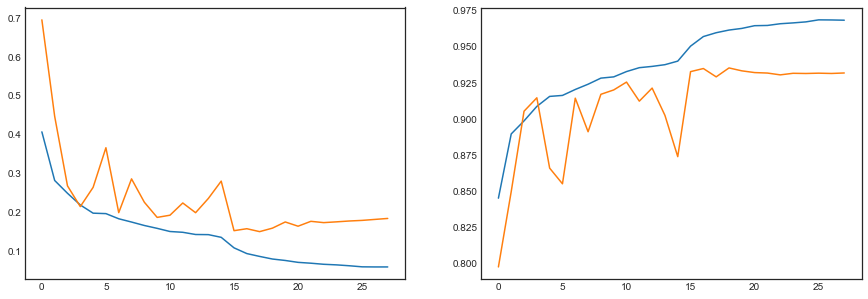

In [22]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [23]:
model = load_model("./keras.model")

# Predict the validation set to do a sanity check
Again plot some sample images including the predictions.

In [24]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

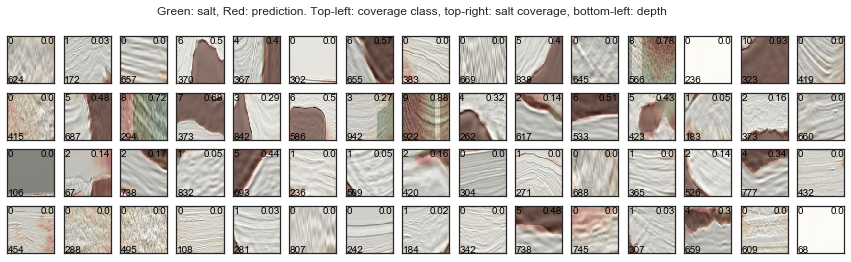

In [25]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Scoring
Score the model and do a threshold optimization by the best IoU.

In [26]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [27]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [28]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

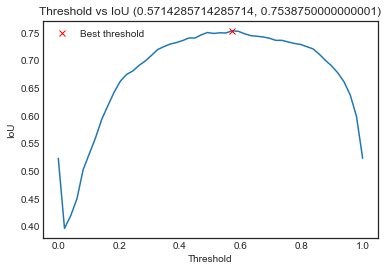

In [29]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Another sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

Text(0.5,0.98,'Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth')

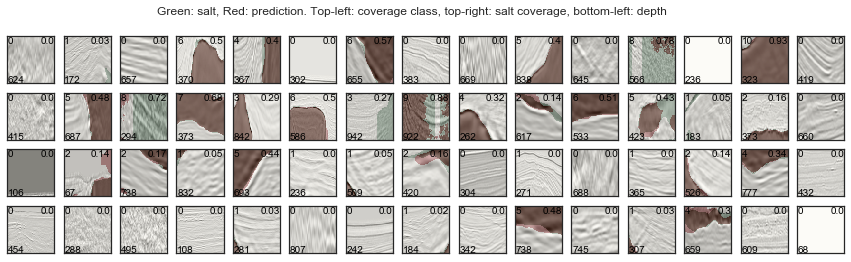

In [30]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

# Submission
Load, predict and submit the test image predictions.

In [31]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [32]:
x_test = np.array([upsample(np.array(load_img("test/images/{}.png".format(idx), grayscale=True))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [33]:
preds_test = model.predict(x_test)

In [34]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [35]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_din_he_v4.csv')